<a href="https://colab.research.google.com/github/knpunk/ForestFire/blob/main/ForestFires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import sklearn.tree as tree
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [9]:
display(df.dtypes)

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

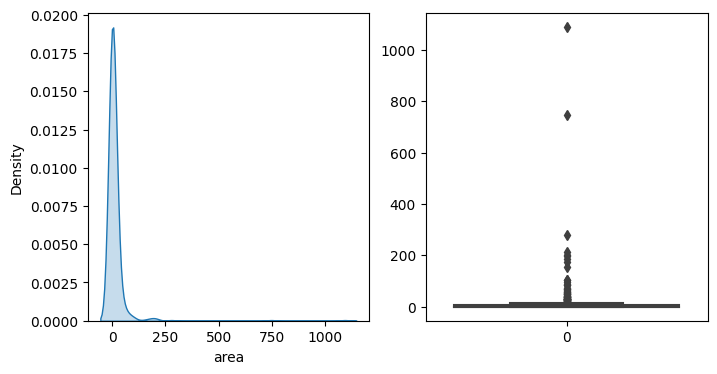

In [10]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(df['area'],fill=True,ax=ax[0])
sns.boxplot(df['area'],ax=ax[1])
fig.show()

Skewness: 12.846933533934868
Skewness after log transform: 1.2178376559535011


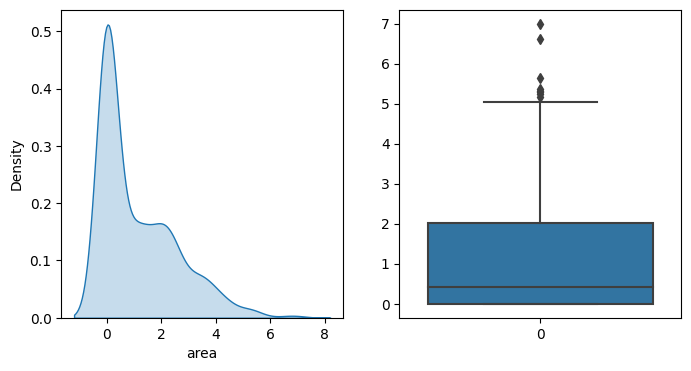

In [11]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(np.log(1+df['area']),fill=True,ax=ax[0])
sns.boxplot(np.log(1+df['area']),ax=ax[1])
fig.show()
area_log = np.log(1 + df['area'])
print('Skewness:',df['area'].skew())
print('Skewness after log transform:',area_log.skew())

In [12]:
df.sort_values(['area'], ascending=[False]).head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48
420,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76
377,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0.0,174.63
234,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0.0,154.88
233,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0.0,105.66


In [13]:
df[df['area'] == 0.]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.0


In [14]:
df[df['area'] == 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.0
mean,4.518219,4.226721,90.219028,106.679757,522.878138,8.851822,18.427935,44.894737,3.913360,0.013765,0.0
std,2.230305,1.289898,6.965969,66.300811,264.637833,4.974102,5.344018,17.581779,1.681857,0.100268,0.0
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,4.200000,15.000000,0.900000,0.000000,0.0
25%,3.000000,4.000000,90.200000,51.300000,360.100000,6.300000,15.200000,32.000000,2.700000,0.000000,0.0
50%,4.000000,4.000000,91.600000,103.200000,661.300000,8.400000,18.600000,42.000000,3.600000,0.000000,0.0
75%,6.000000,5.000000,92.600000,142.400000,706.500000,10.600000,21.600000,54.000000,5.150000,0.000000,0.0
max,9.000000,9.000000,96.200000,290.000000,855.300000,56.100000,32.400000,100.000000,8.500000,1.000000,0.0


In [15]:
df[df['area'] != 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


In [16]:
dfa = df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()
print('Categorical features:',cat_columns)
print('Numerical features:',num_columns)

Categorical features: ['month', 'day']
Numerical features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


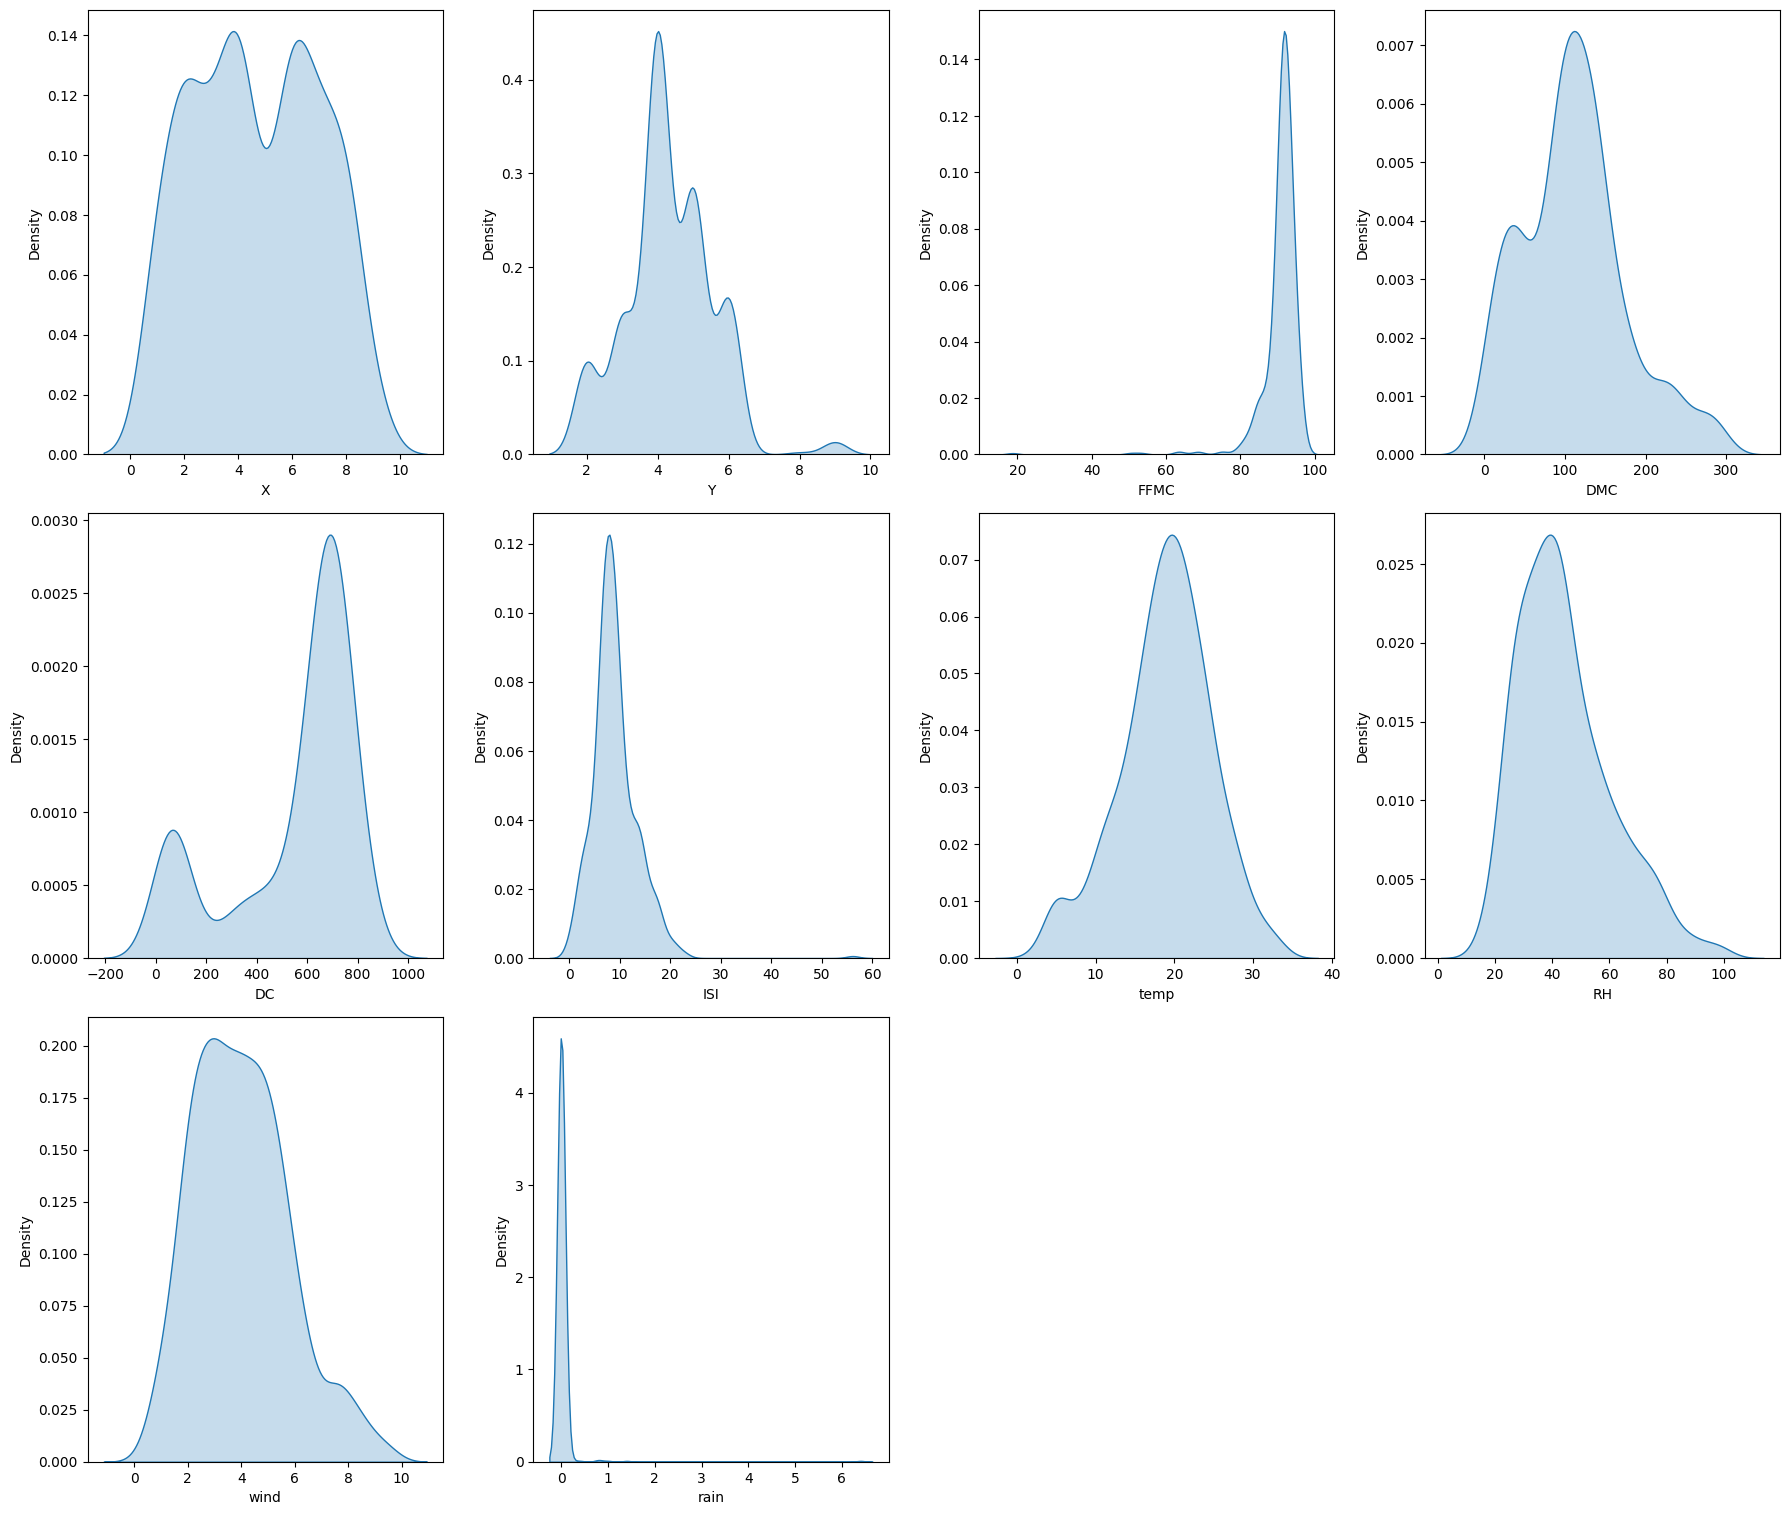

In [17]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],fill=True)
plt.tight_layout()
plt.show()

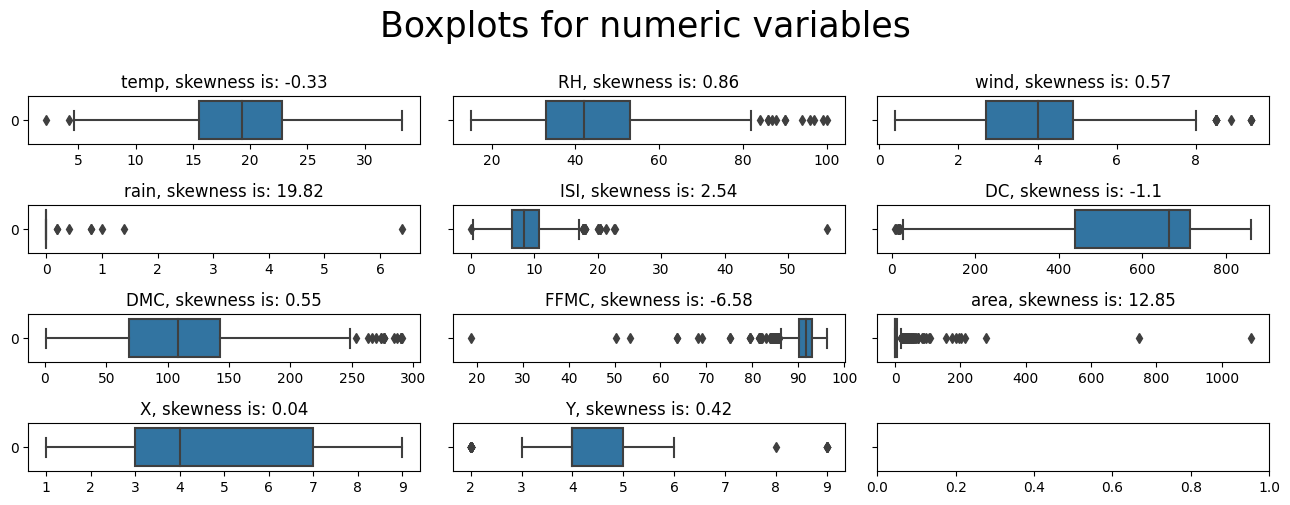

In [18]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

numerical_columns = list(df.loc[:,['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','X','Y' ]])

boxplots_custom(dataset=df, columns_list=numerical_columns, rows=4, cols=3, suptitle='Boxplots for numeric variables')
plt.tight_layout()

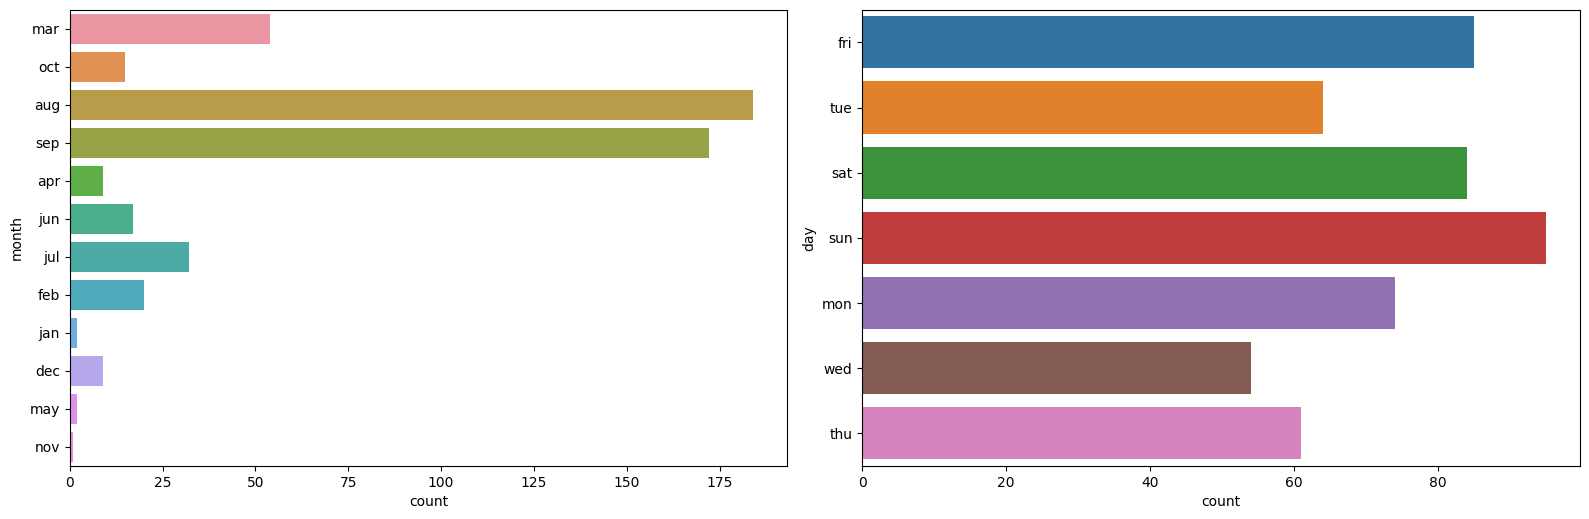

In [19]:
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df,y=col)
plt.tight_layout()
plt.show()

In [20]:
print('Number of rows with no damage:',df[df['area'] == 0.].shape[0])
print('Number of rows with damage:',df[df['area'] != 0.].shape[0])

Number of rows with no damage: 247
Number of rows with damage: 270


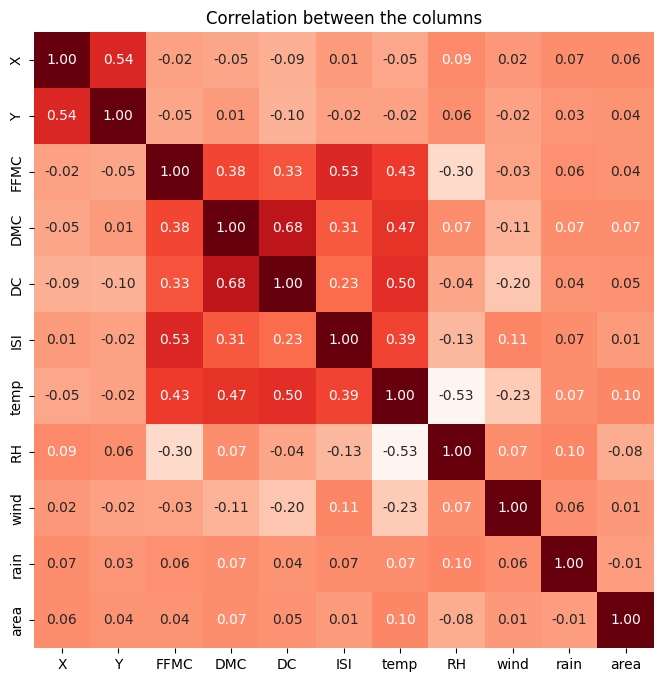

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Reds', fmt='.2f')
plt.title("Correlation between the columns")
plt.show()

<Axes: >

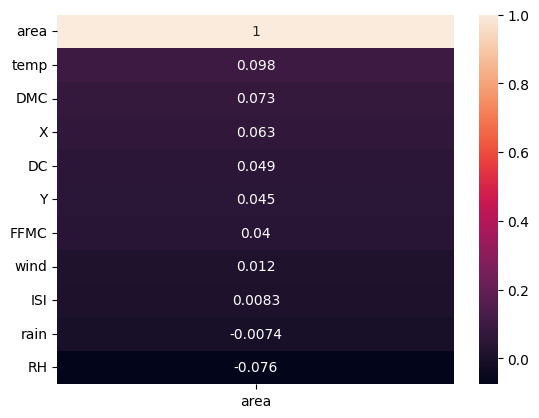

In [22]:
corr = df.corr()[['area']].sort_values(by='area', ascending=False)
sns.heatmap(corr, annot=True)

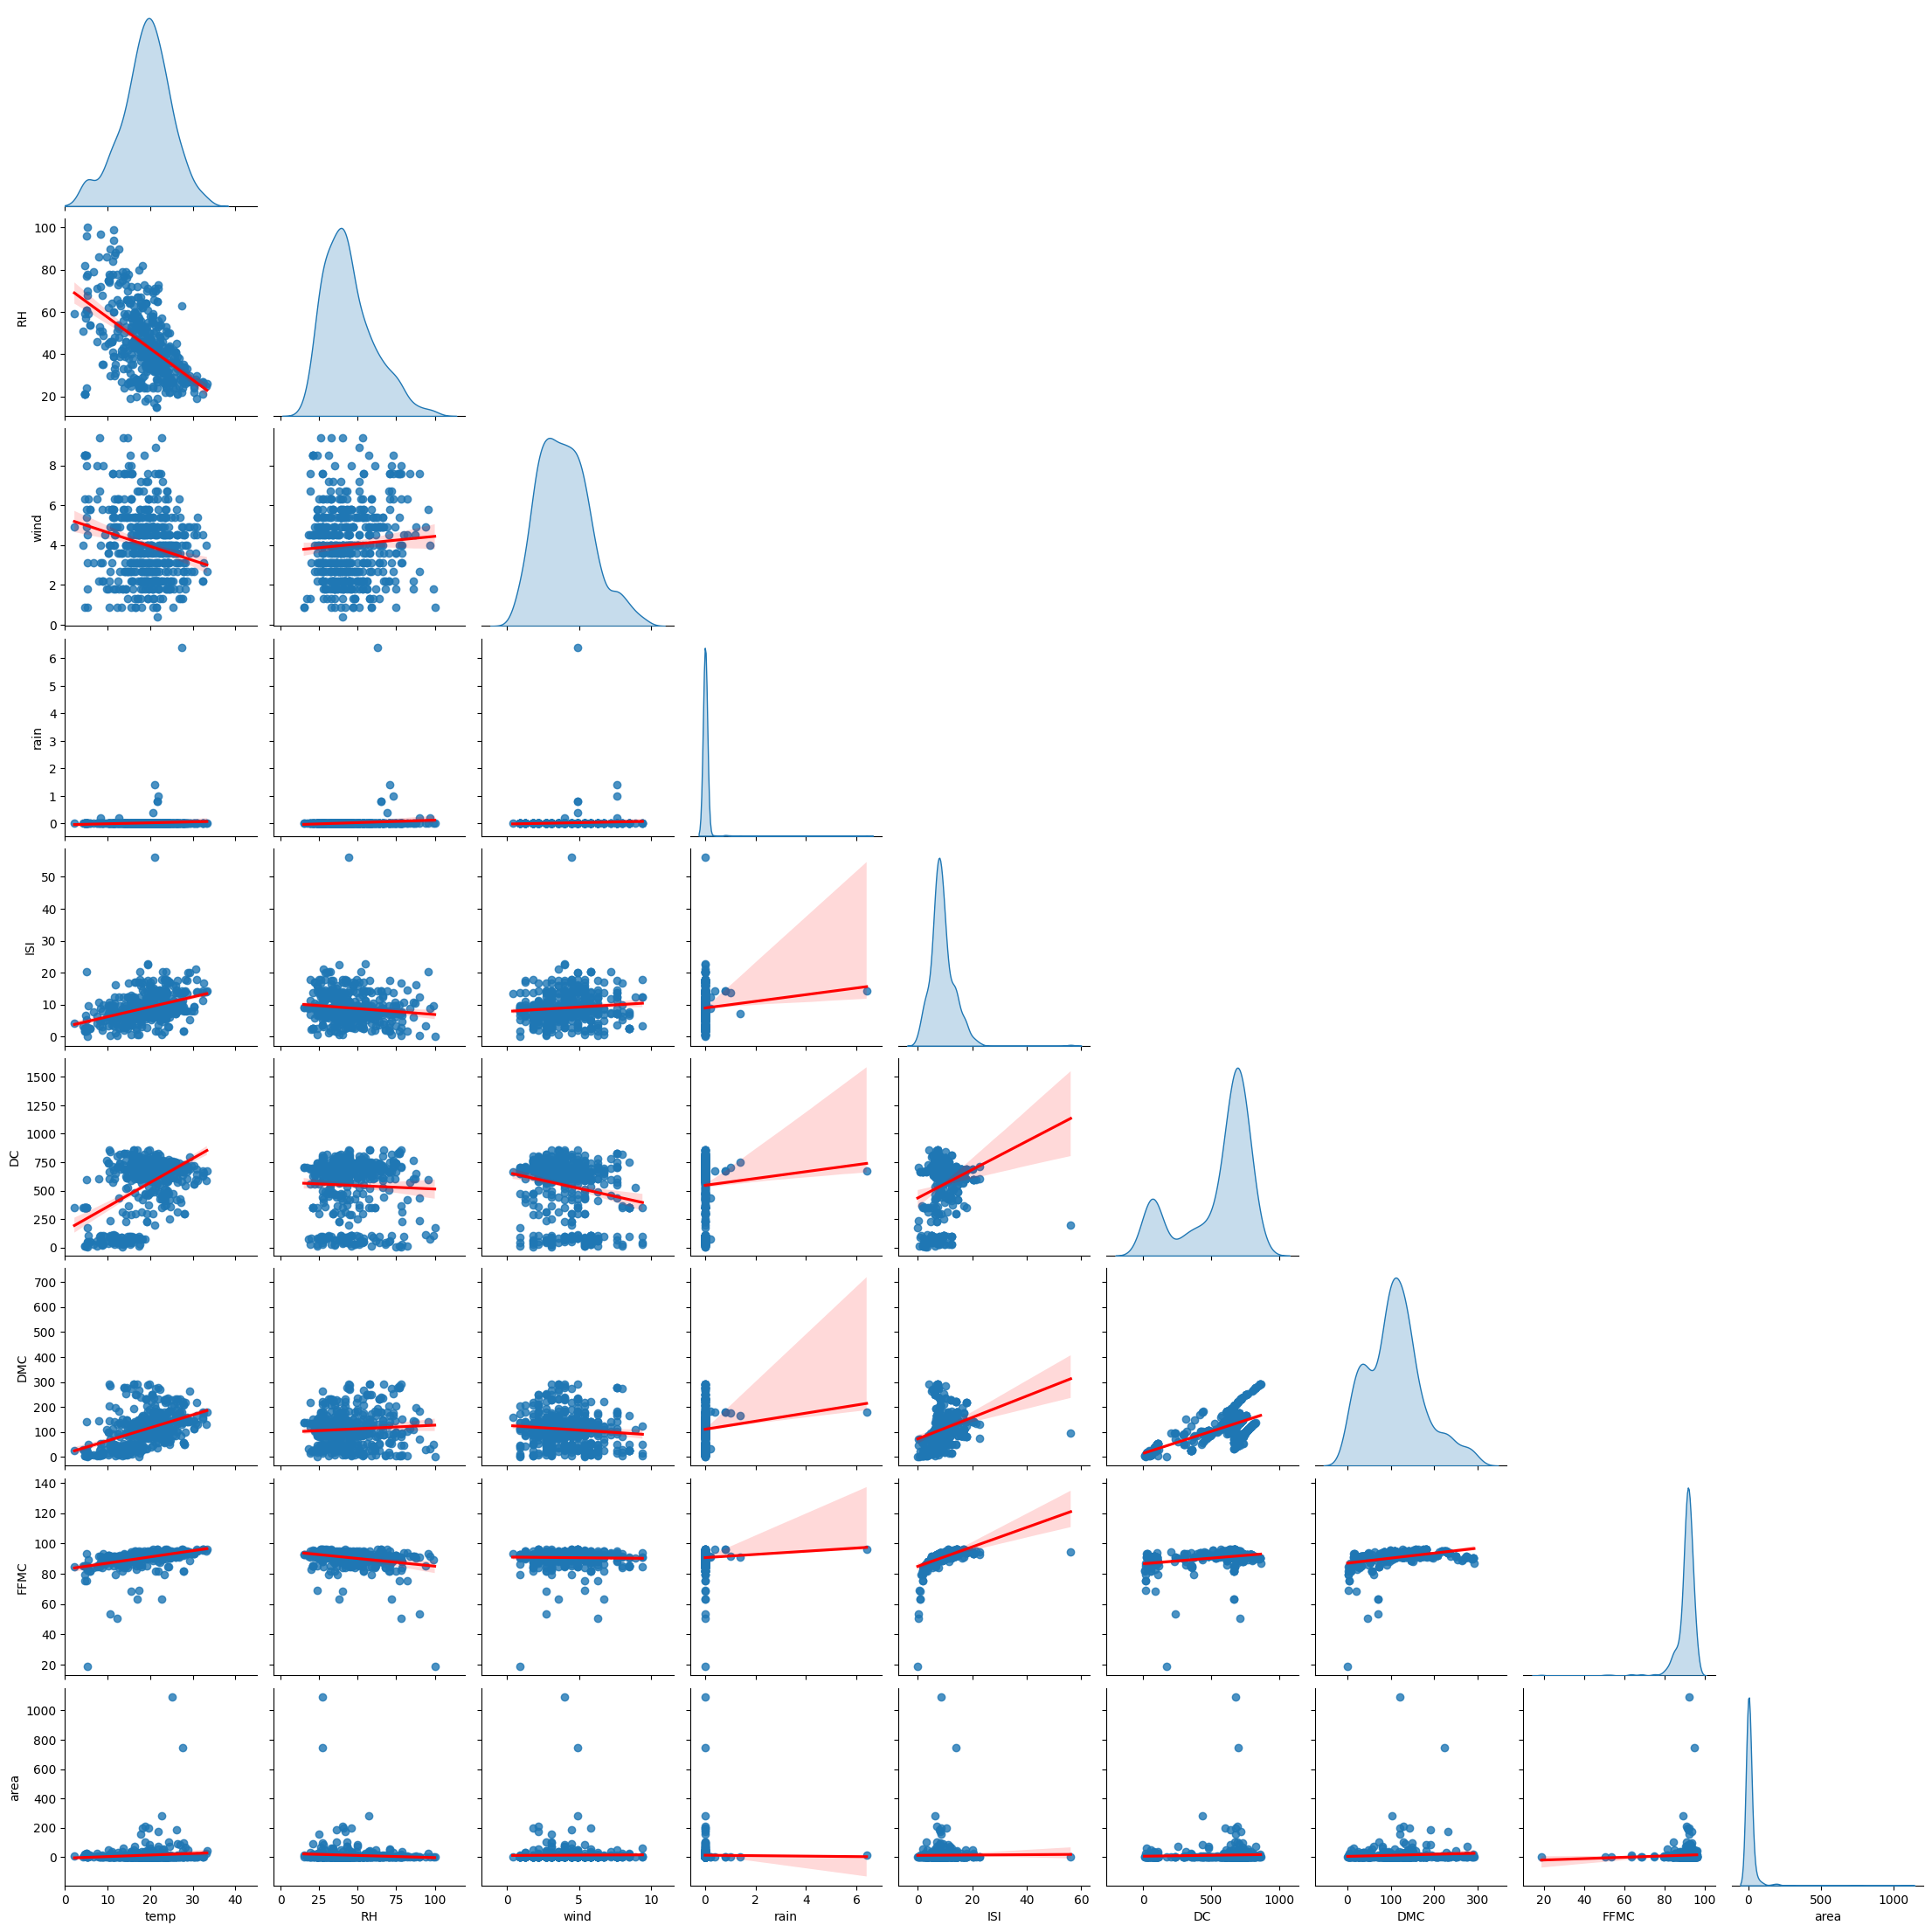

In [23]:
cols_plot = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area']
g = sns.pairplot(df[cols_plot],diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))

In [24]:
def damage_func(area):
    if area == 0.0:
        return "No damage"
    else:
        return "Damage"

df['damage'] = df['area'].apply(damage_func)

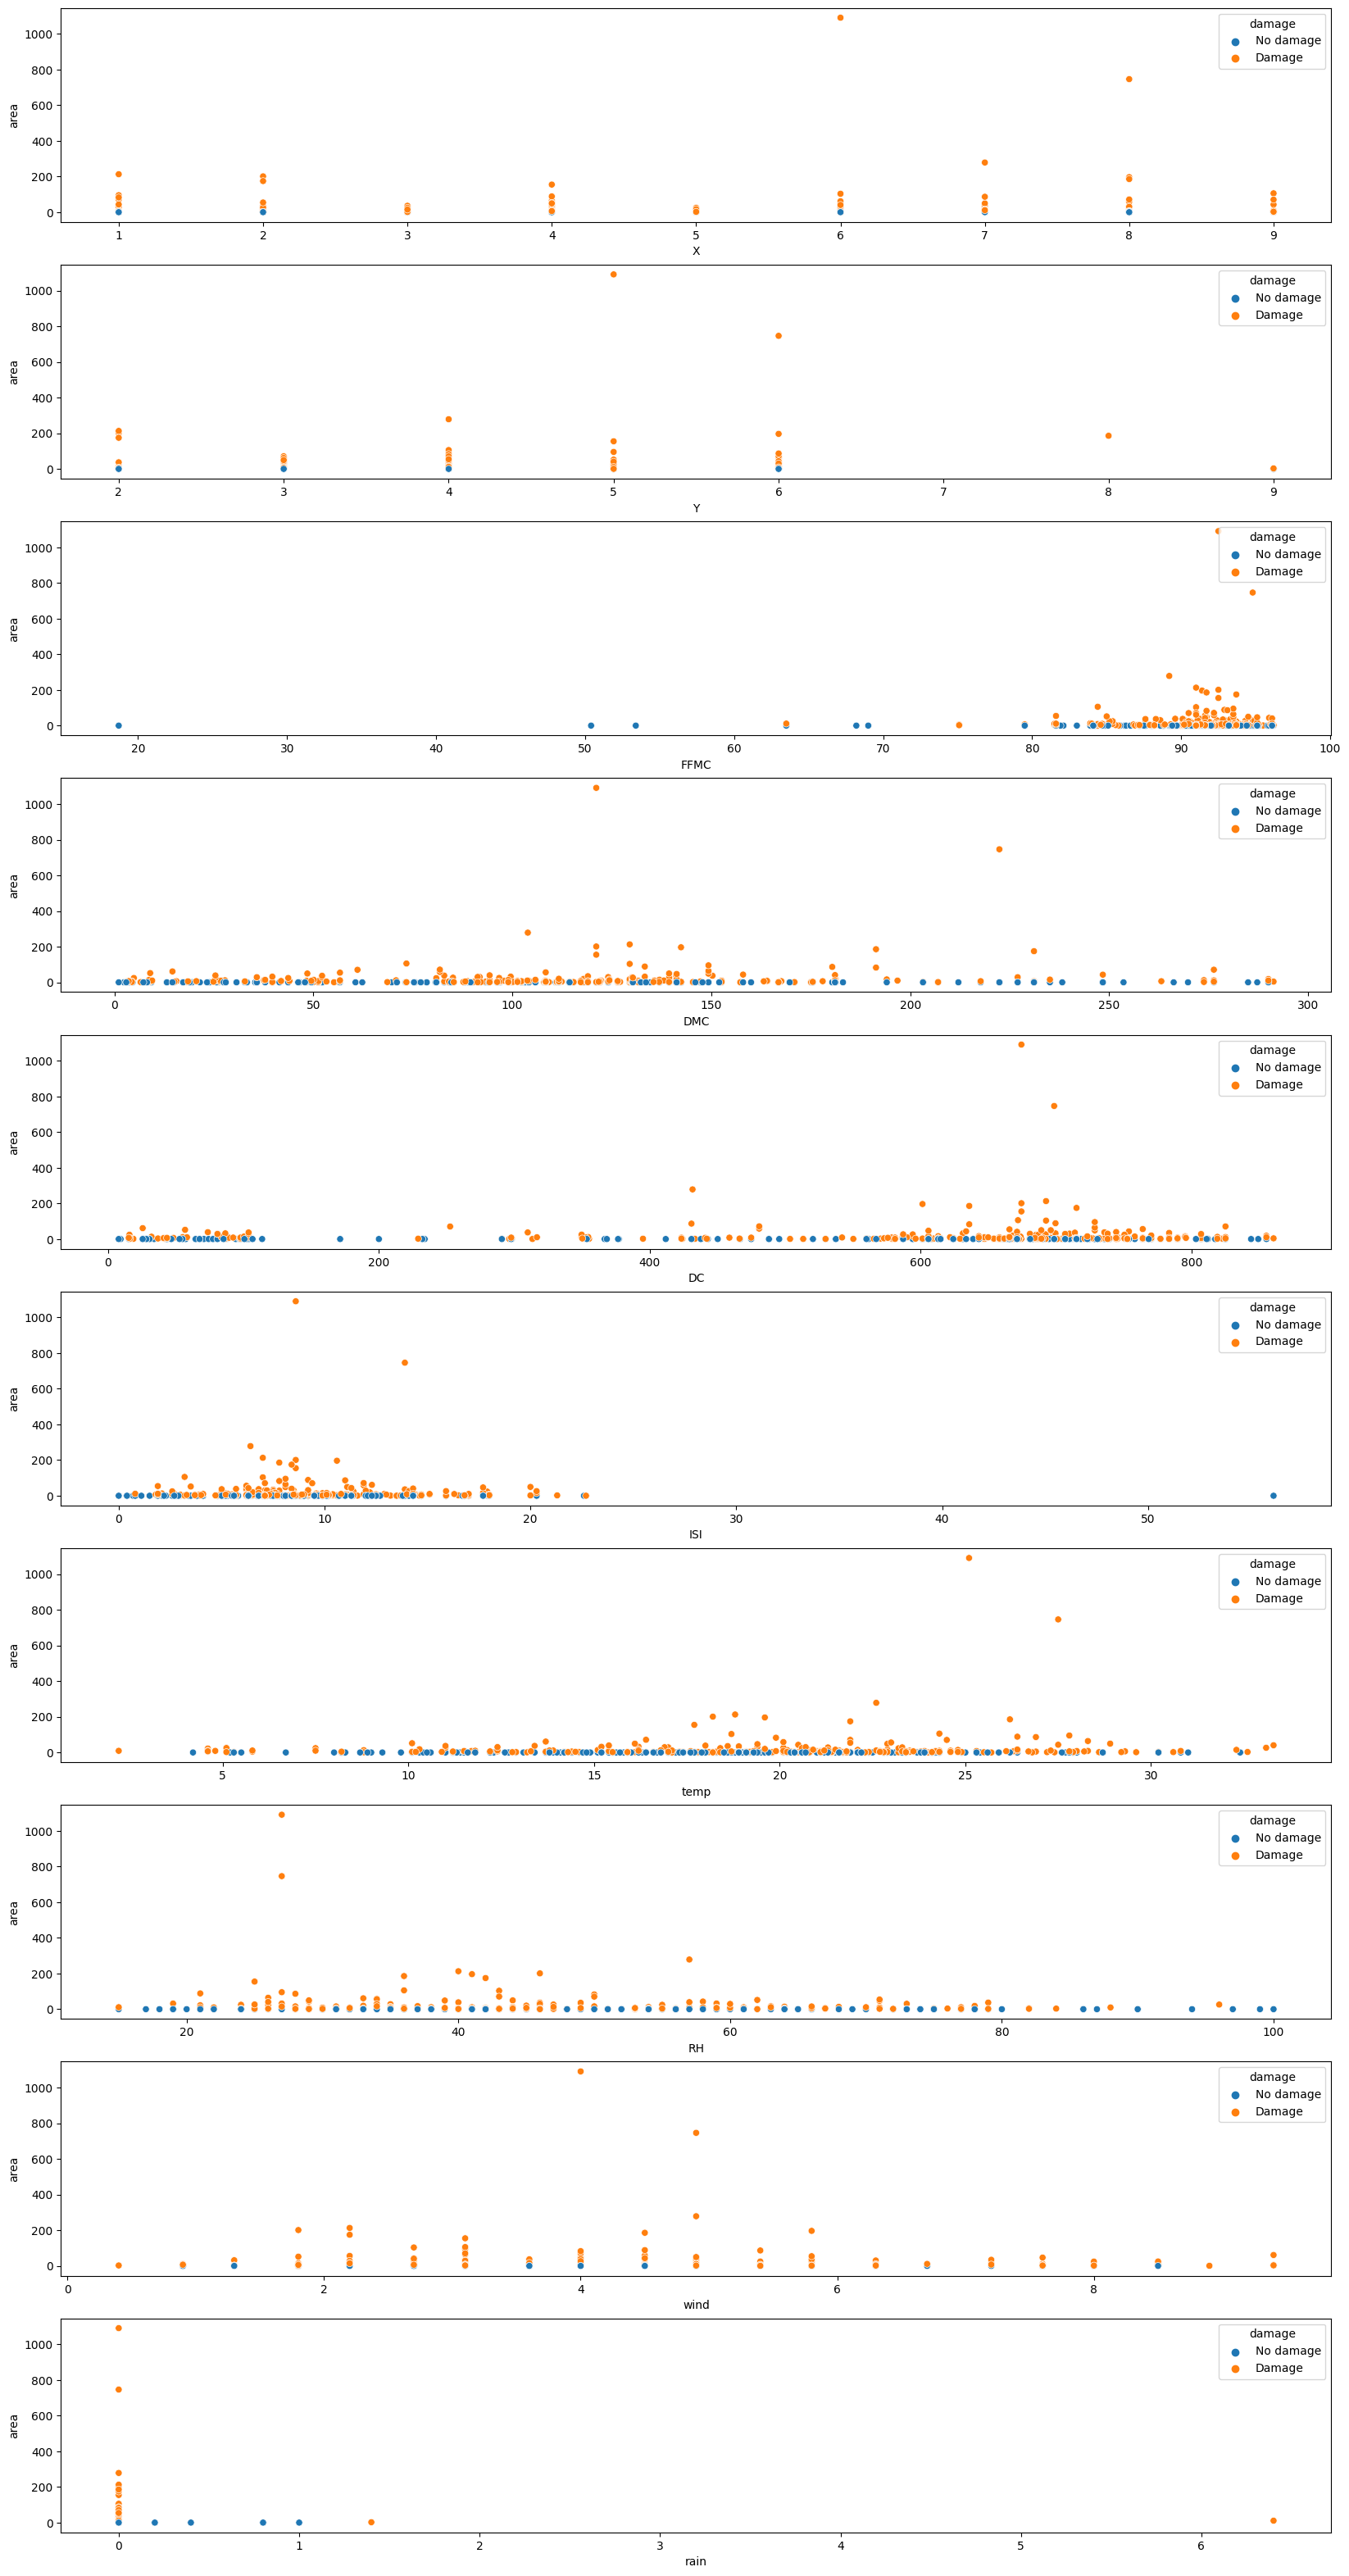

In [25]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    sns.scatterplot(data=df,x=col,y='area',hue='damage')
plt.show()


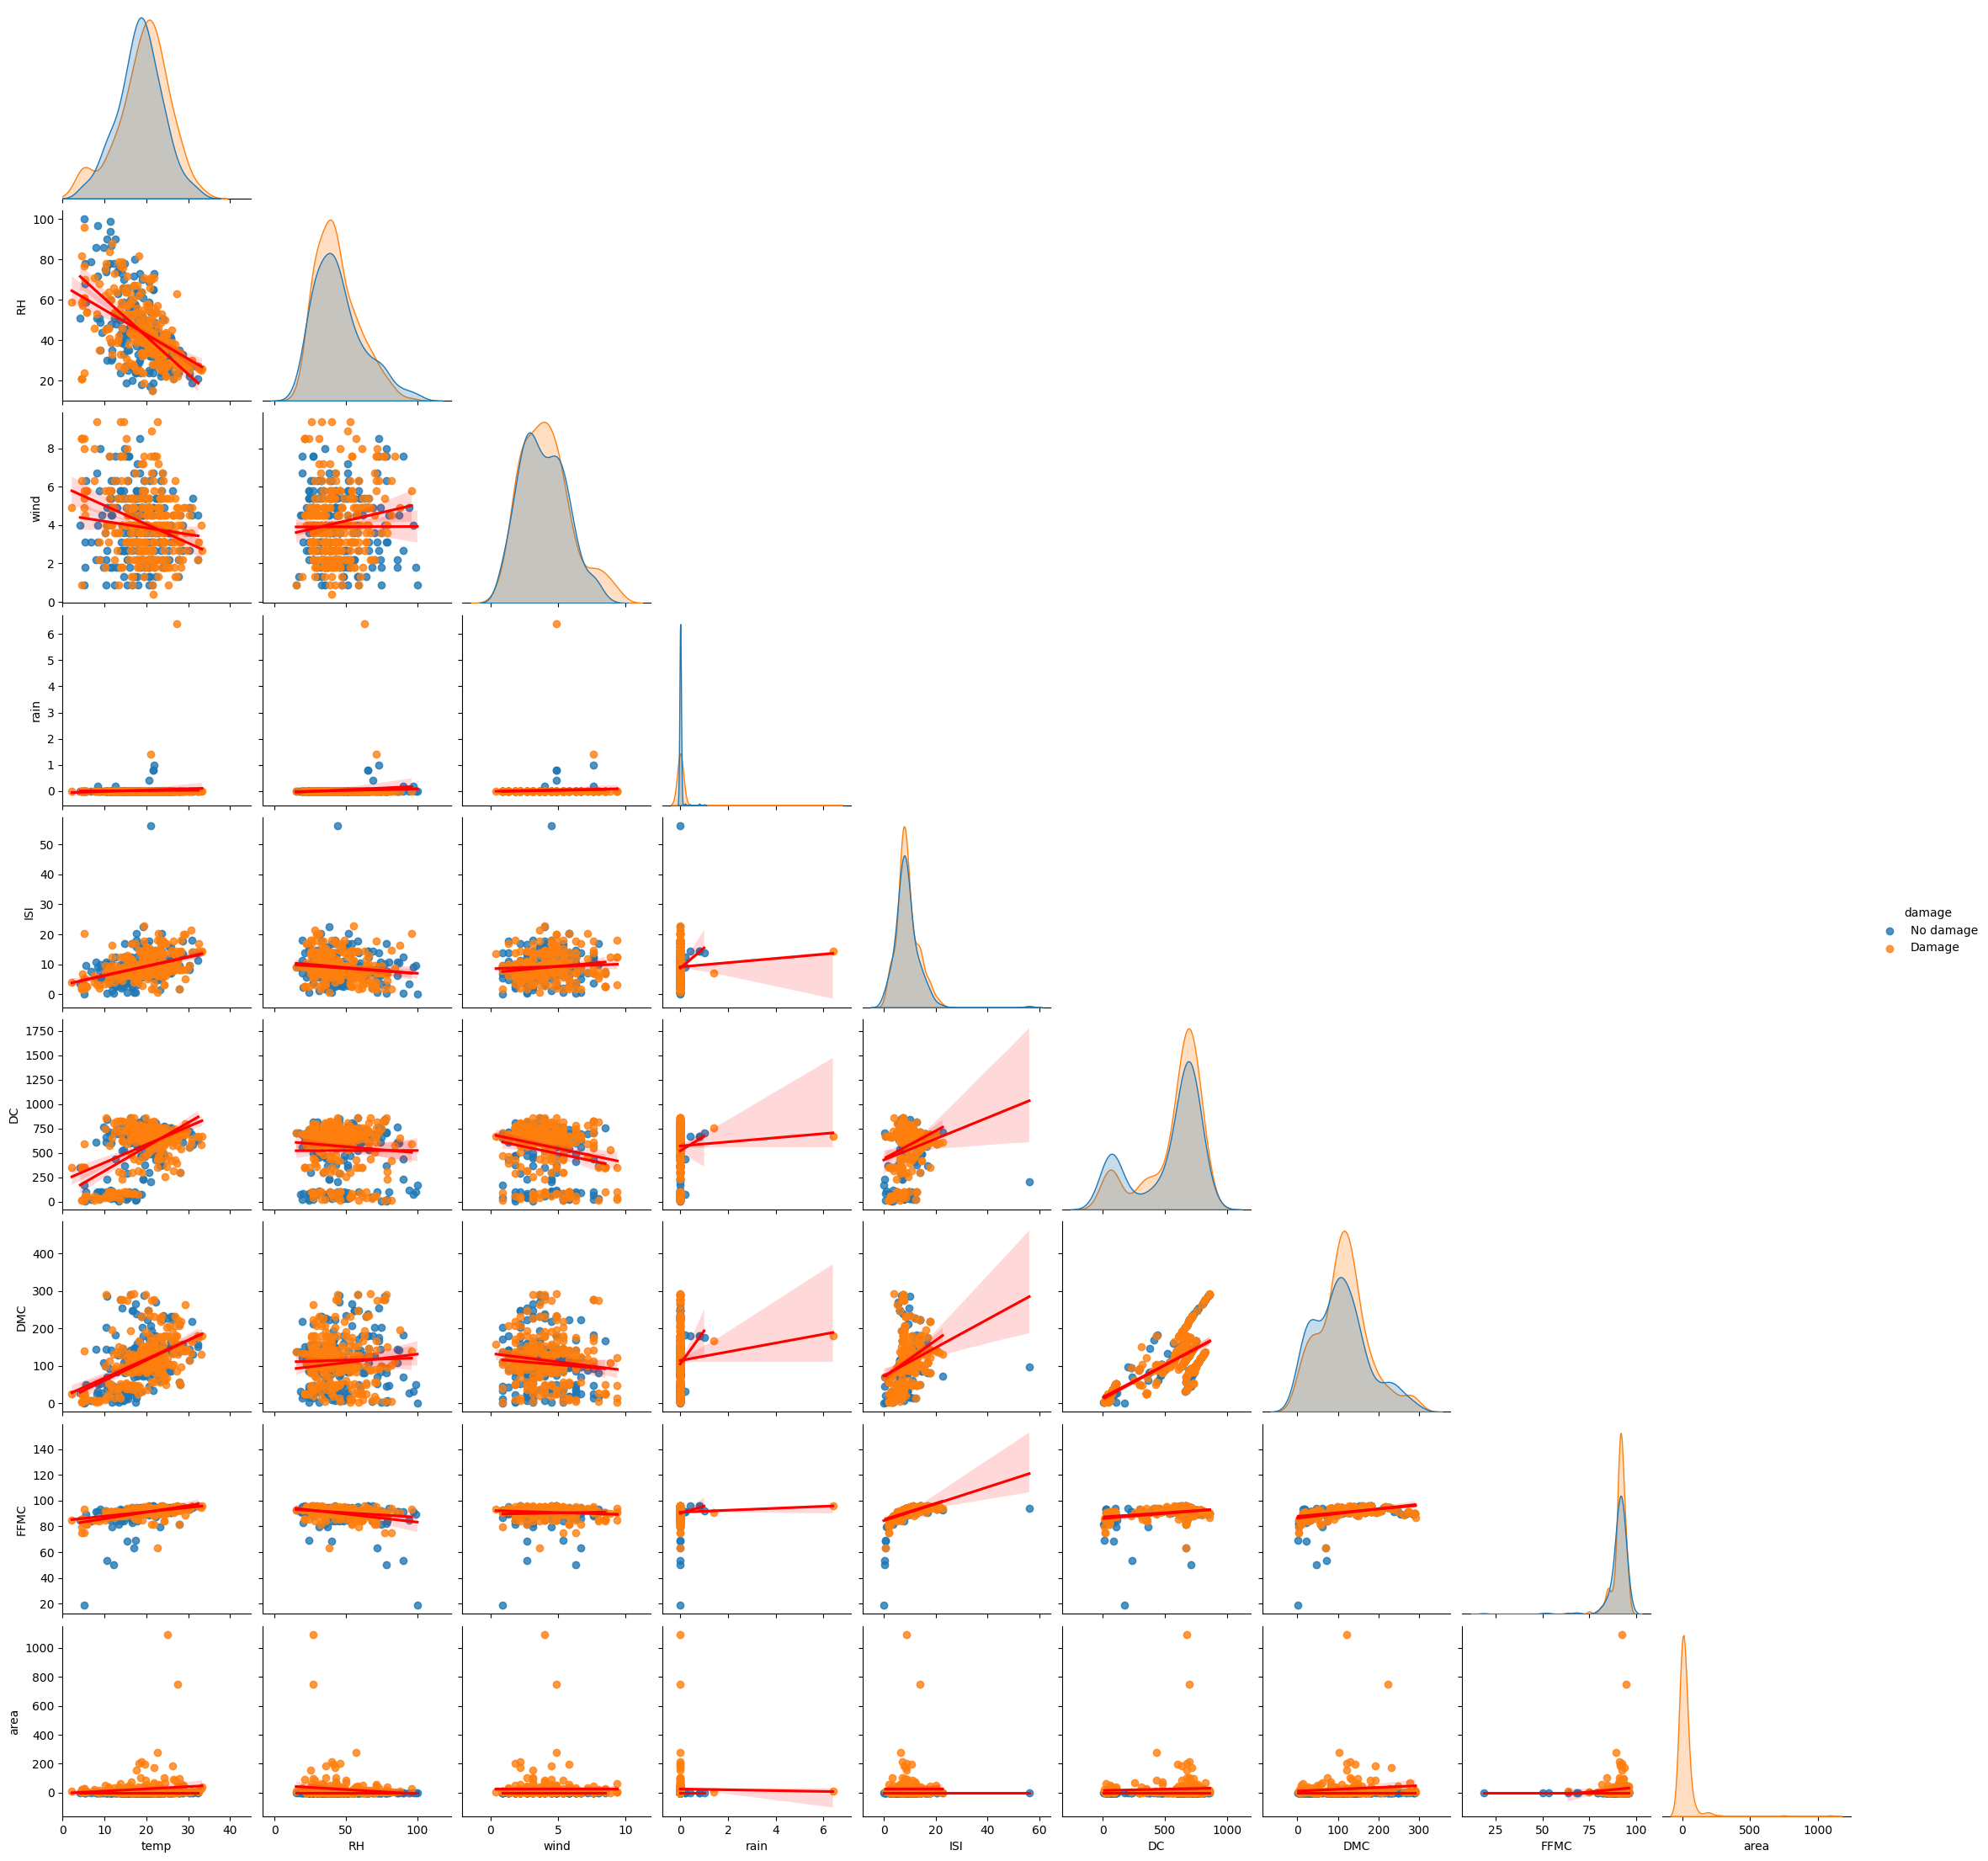

In [26]:
cols_plothue = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','damage']
g = sns.pairplot(df[cols_plothue],hue='damage',diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))
plt.show()

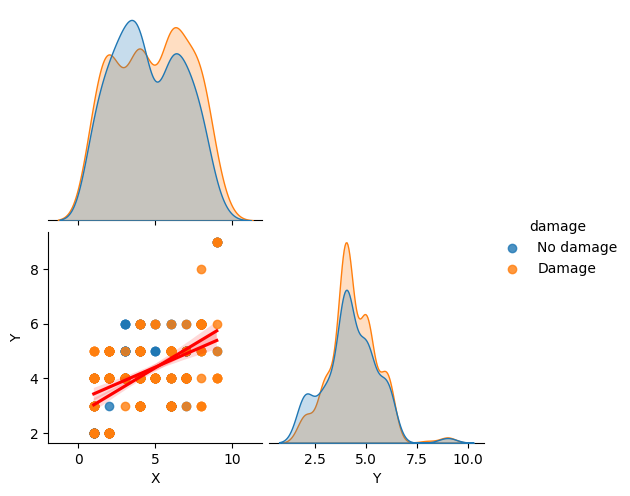

In [27]:
sns.pairplot(df[['X','Y','damage']],hue='damage',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
#for i in range(len(cols_plot)):
#    g.axes[i,0].set_xlim((0,45))
plt.show()

In [28]:
df = df.drop('damage', axis=1)

In [29]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

MODEL BUILDING

In [30]:
df['area'] = np.log(1 + df['area'])

# Creating bins of in the target, to stratify in train/test split
df['area_bin'] = pd.cut(df['area'], 5)
X = df.drop(columns='area')
y = df['area']

In [31]:
rmse_res = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=i,
                                                   stratify=df[['area_bin']])
    X_train = X_train.drop(columns='area_bin',axis=1)
    X_test = X_test.drop(columns='area_bin',axis=1)

    lr = LinearRegression()

    lr.fit(X_train, Y_train)
    y_pred = np.exp(lr.predict(X_test)) - 1
    rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
    #print('Random state = ',i)
    #print(f'RMSE: {rmse}')
    rmse_res.append(rmse)

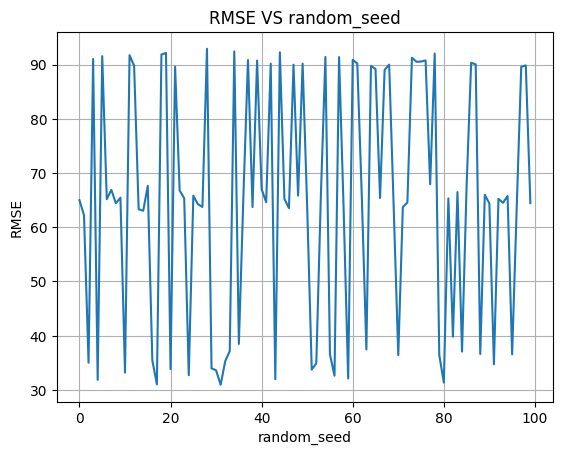

Mean:  64.76060698955546
Stdev:  21.732525937265823


In [32]:
plt.plot(rmse_res)
plt.title("RMSE VS random_seed")
plt.xlabel('random_seed')
plt.ylabel('RMSE')
plt.grid()
plt.show()
print('Mean: ',np.mean(rmse_res))
print('Stdev: ',np.std(rmse_res))

In [33]:
rs = 99
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=rs,
                                                   stratify=df[['area_bin']])
X_train = X_train.drop(columns='area_bin',axis=1)
X_test = X_test.drop(columns='area_bin',axis=1)

In [34]:
def Grid_and_eval(classifier,params,cv=10):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,
                            scoring='neg_root_mean_squared_error',
                            verbose=0,
                            error_score=np.nan)
    model_cv.fit(X_train,Y_train)
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)

    y_pred_test = np.exp(best_model.predict(X_test)) - 1
    y_pred_Train = np.exp(best_model.predict(X_train)) - 1
    rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
    rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)

    print(f'Test RMSE: {rmse_Test}')
    print(f'Train RMSE: {rmse_Train}')
    mae = mean_absolute_error(np.exp(Y_test)-1, y_pred_test)
    print(f'Test MAE: {mae}')

In [35]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

y_pred = np.exp(lr.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred)
print(f'Test set RMSE: {rmse}')
print(f'Test set MAE: {mae}')

y_pred = np.exp(lr.predict(X_train)) - 1
rmse = mean_squared_error(np.exp(Y_train)-1, y_pred,squared=False)
print(f'Train RMSE: {rmse}')

Test set RMSE: 64.43626049084423
Test set MAE: 13.848830422339942
Train RMSE: 64.16473380074774


In [36]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, Y_train)
y_pred = np.exp(pipe.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
print(f'Test set RMSE: {rmse}')

Test set RMSE: 64.43626049084423


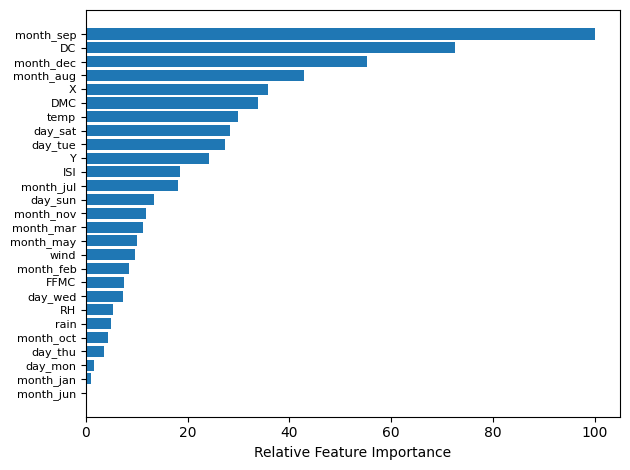

In [37]:
feature_importance = abs(pipe[-1].coef_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
#print(sorted_idx)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()
plt.show()

RMSE: 64.30708192713162
MAE: 13.823962690902421


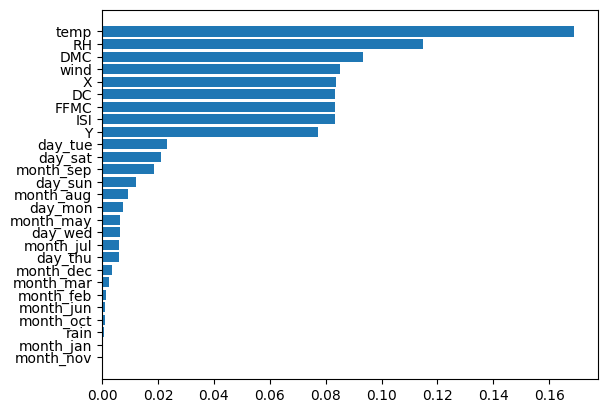

In [38]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

y_pred = np.exp(rf.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Feature importance ----------------
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [39]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
result = Grid_and_eval(RandomForestRegressor(random_state=rs),{
    'n_estimators': [100,300,500],
    'max_depth': [None,1,2],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3,4]
},cv=10)


Tuned hyperparameters:  {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}
Mean CV score of best_estimator, on Training: -1.381714176408448
Best estimator: RandomForestRegressor(max_depth=1, min_samples_leaf=3, n_estimators=500,
                      random_state=99)
Test RMSE: 64.4780096676812
Train RMSE: 64.46740603536259
Test MAE: 13.825770182400415


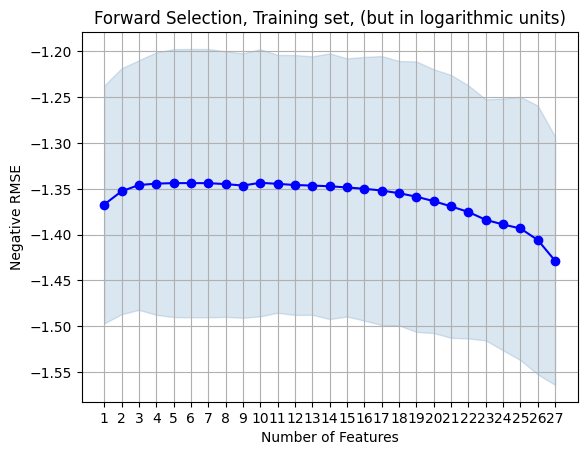

Best feature combo: ('X', 'Y', 'temp', 'RH', 'day_tue', 'month_dec', 'month_jan', 'month_jul', 'month_nov', 'month_sep')
Test RMSE: 64.48315651394954
Train RMSE: 64.35857362053594


In [40]:
model = LinearRegression()
sfs1 = sfs(model,k_features="best",
           forward=True,
           scoring='neg_root_mean_squared_error',
           cv=5)
sfs1.fit(X_train,Y_train)

#Plot performance ------------------------
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection, Training set, (but in logarithmic units)')
plt.ylabel('Negative RMSE')
plt.grid()
plt.show()


print("Best feature combo:",sfs1.k_feature_names_)

# Refit with only best features ------------------------
X_train_sele = sfs1.transform(X_train)
X_test_sele = sfs1.transform(X_test)
model.fit(X_train_sele,Y_train)
y_pred_test = np.exp(model.predict(X_test_sele)) - 1
y_pred_Train = np.exp(model.predict(X_train_sele)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')

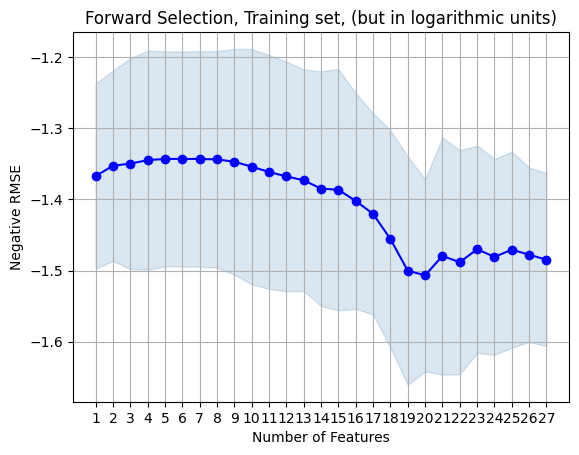

Best feature combo: ('day_tue', 'month_dec', 'month_mar', 'month_oct', 'month_sep')
Test RMSE: 64.54135188695393
Train RMSE: 64.370463832622


In [41]:
model = RandomForestRegressor(random_state=rs)
sfs1 = sfs(model,k_features="best",
           forward=True,
           scoring='neg_root_mean_squared_error',
           cv=5)
sfs1.fit(X_train,Y_train)

#Plot performance ------------------------
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection, Training set, (but in logarithmic units)')
plt.ylabel('Negative RMSE')
plt.grid()
plt.show()


print("Best feature combo:",sfs1.k_feature_names_)

# Refit with only best features ------------------------
X_train_sele = sfs1.transform(X_train)
X_test_sele = sfs1.transform(X_test)
model.fit(X_train_sele,Y_train)
y_pred_test = np.exp(model.predict(X_test_sele)) - 1
y_pred_Train = np.exp(model.predict(X_train_sele)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')